# W266 Authorship Attribution

By Tessa de Vries, Shanie Hsieh, & Shirley Jiang

MIDS Spring 2022

## Importing Libraries

In [1]:
!pip install -q transformers
!pip install -q datasets
#!pip install datasets

     |████████████████████████████████| 4.0 MB 8.7 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 895 kB 46.7 MB/s 
     |████████████████████████████████| 6.5 MB 37.5 MB/s 
     |████████████████████████████████| 325 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 54.3 MB/s 
     |████████████████████████████████| 212 kB 51.4 MB/s 
     |████████████████████████████████| 136 kB 43.4 MB/s 
     |████████████████████████████████| 127 kB 60.0 MB/s 
     |████████████████████████████████| 271 kB 58.9 MB/s 
     |████████████████████████████████| 144 kB 37.0 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is

In [2]:
import numpy as np 
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from datasets import Dataset
# Use HuggingFace's datasets object
from datasets import load_dataset
from transformers import AutoTokenizer

import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import nltk
nltk.download('popular')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

### Useful Functions

- Create paragraph function
  - [Remove unwanted spaces from string with regex](https://www.geeksforgeeks.org/python-remove-unwanted-spaces-from-string/)
  - [NLTK tokenize](https://www.nltk.org/api/nltk.tokenize.html)

In [5]:
def paragraphs(text):
  """
  Turn documents into paragraphs using /n/n linebreaks 
  and replacing /n newlines with spaces
  """
  paras = [i for i in text.split("\n\n") if i != ""]
  rm_linebreak = [i.replace('\n', ' ') for i in paras]
  unif_spaces = [re.sub(' +', ' ', i) for i in rm_linebreak]
  return unif_spaces

- Plot a nice [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [6]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a sklearn confusion matrix (cm), make a nice plot
    
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Data Retrieval
Our dataset was generated using the [Project Gutenberg book API](https://github.com/c-w/Gutenberg) \(Also seen on [PyPl](https://pypi.python.org/pypi/Gutenberg)). 

Our data generation notebook can be found [here](https://colab.research.google.com/drive/1PHUzNh1Giobto7WriB48osfbDFvyvsL4) 

For ease of access and narrative continuity, the code is also in the following section. 

**⚠ Be aware, running this code includes caching Project Gutenberg book metadata, which will take around an hour to complete. ⚠**

---
Set the working directory for this notebook for ease of access to files.

From here on out, the notebook assumes that the [`W266 Term Project` (link)](https://colab.research.google.com/drive/1BhZ_wnrnTx1Mn4hia4xxEcZ92d3-iwtm?usp=sharing) folder is a shortcut in your Google Drive main/homepage (My Drive)

### Clone Repo

In [ ]:
!git clone https://github.com/c-w/Gutenberg.git

fatal: destination path 'Gutenberg' already exists and is not an empty directory.


### Install BDS-DB3 and Dependences

In [ ]:
#linux installation of bsddb3
!sudo apt-get install libdb++-dev
!export BERKELEYDB_DIR=/usr
!pip install .
!sudo apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libdb++-dev is already the newest version (1:5.3.21~exp1ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
cd Gutenberg/

/content/Gutenberg


In [ ]:
!pip install virtualenv
!virtualenv --no-site-packages virtualenv
!. virtualenv/bin/activate
!pip install -r requirements-dev.pip
!pip install .

usage: virtualenv [--version] [--with-traceback] [-v | -q] [--read-only-app-data] [--app-data APP_DATA] [--reset-app-data] [--upgrade-embed-wheels] [--discovery {builtin}] [-p py] [--try-first-with py_exe]
                  [--creator {builtin,cpython3-posix,venv}] [--seeder {app-data,pip}] [--no-seed] [--activators comma_sep_list] [--clear] [--no-vcs-ignore] [--system-site-packages] [--symlinks | --copies] [--no-download | --download]
                  [--extra-search-dir d [d ...]] [--pip version] [--setuptools version] [--wheel version] [--no-pip] [--no-setuptools] [--no-wheel] [--no-periodic-update] [--symlink-app-data] [--prompt prompt] [-h]
                  dest
virtualenv: error: unrecognized arguments: --no-site-packages
SystemExit: 2
/bin/bash: virtualenv/bin/activate: No such file or directory
Processing /content/Gutenberg
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use -

### Load Metadata/Cache book metadata

In [ ]:
# Get book text by using book id
from gutenberg.acquire import load_etext
# Remove "The Project Gutenberg eBook" header text
from gutenberg.cleanup import strip_headers

In [ ]:
from gutenberg.query import list_supported_metadatas
print(list_supported_metadatas()) # prints (u'author', u'formaturi', u'language', ...)

('author', 'formaturi', 'language', 'rights', 'subject', 'title')


In [ ]:
from gutenberg.acquire import get_metadata_cache
cache = get_metadata_cache()
cache.populate()

### Create dataset with text data/inputs and author labels/outputs

In [ ]:
from pandas.core.dtypes.common import is_datetime64tz_dtype
from gutenberg.query import get_etexts
from gutenberg.query import get_metadata

sample_txt_ids = [
                  1513, 1524, 1533, 1112, 1514, 1531, 1522, 1532, 1515, 1519, # William Shakespeare
                  1342, 158, 161, 105, 121, 141, 946, 42078, 1212, # Jane Austen
                  98, 1400, 730, 766, 1023, 580, 883, 700, 967, 1289, 807, 25852, # Charles Dickens
                  205, 71, 1022, 34392, 42553, 4232, 34990, 42500, 9846, 60951, # Henry David Thoreau
                  140, 38117, 63293, 63693, 7522, 5421, 5776, 65576, 3304, 5774, # Upton Sinclair
                  64317, 805, 6695, 4368, 60962, # F. Scott Fitzgerald
                  1661, 2852, 244, 2097, 834, 139, 108, 903, 537, 2347, # Arthur Conan Doyle
                  16, 26654, 20914, 1376, 18934, 4021, 3490, 9617, 342, 6965, # J.M Barrie
                  76, 74, 86, 1837, 3176, 245, 3177, 3189, 3174, 119, # Mark Twain
                  84, 18247, 15238, 56665, 6447, 66749, 66545, 64329, 63337, 64555, # Mary Shelley
                  1497, 1656, 1672, 1750, 1600, 1636, 1726, 1658, 1642, 1572, # Plato
                  2148, 2147, 932, 1064, 32037, 1063, 2151, 2149, 17192, 2150, # Edgar Allan Poe
                  55, 520, 54, 22566, 4357, 33361, 419, 41667, 26624, 52176, # Lyman Frank Baum
                  408, 15210, 62582, 15265, 66398, 17700, 15359, 31254, 62799, 5685, # W.E.B. Du Bois
                  204, 1695, 1717, 1719, 130, 67639, 8092, 470, 223, 65688, # Gilbert Keith Chesterton
                  45, 47, 51, 544, 3796, 5343, 61236, 1354, 5342, 316, # Lucy Maude Montgomery
                  34568, 35601, 34550, 34737, 34582, 35013, 35070, 35157, 35097, 35128, # Thomas Tapper
                  25344, 13707, 77, 2081, 976, 32242, 513, 9243, 1916, 512, # Nathaniel Hawthorne
                  219, 220, 5658, 974, 2021, 17731, 1142, 1202, 495, 2480, # Joseph Conrad
                  863, 61262, 58866, 1155, 61168, 67173, 67160, 65238, 66446 # Agatha Christie
                  ]

def text_extractor(txt_id):
  txt = strip_headers(load_etext(etextno=txt_id))
  #return nltk.word_tokenize(txt)
  return txt

def metadata_getter(feat_name, txt_id):
  return str(list(get_metadata(feat_name, txt_id)))[2:-2]

data = {"text": [],
        "author" :[],
        "etxt_id" : [],
        "title" : [], 
        "subject" : []
        }

for id in sample_txt_ids:
  # Keep only etexts with singular attributed author
  assert len(get_metadata("author", id)) == 1, f"Author issue! Check etextno: {id}"
  data['text'].append(text_extractor(id))
  data['author'].append(metadata_getter('author', id))
  data["etxt_id"].append(id)
  data['title'].append(metadata_getter('title', id))
  data['subject'].append(metadata_getter('subject', id))

df = pd.DataFrame(data)

In [ ]:
author_vals = {k:v for k, v in list(zip(np.arange(0, len(pd.factorize(df.author)[1])), pd.factorize(df.author)[1]), )}
df["author_label"] = pd.factorize(df.author)[0]
df.head(50)

text                author  \
0   \n\n\n\nTHE TRAGEDY OF ROMEO AND JULIET\n\n\n\...  Shakespeare, William   
1   \n\n\n\nTHE TRAGEDY OF HAMLET, PRINCE OF DENMA...  Shakespeare, William   
2   \ncover \n\n\n\nMACBETH\n\nby William Shakespe...  Shakespeare, William   
3   \n\n\n\n\n\n\n\n\n\n\n\n\n*Project Gutenberg i...  Shakespeare, William   
4   \ncover \n\n\n\n\nA MIDSUMMER NIGHT’S DREAM\n\...  Shakespeare, William   
5   \ncover \n\n\n\nOTHELLO, THE MOOR OF VENICE\n\...  Shakespeare, William   
6   \n\n\n\nTHE TRAGEDY OF JULIUS CAESAR\n\n\nby W...  Shakespeare, William   
7   \n\n\n\nTHE TRAGEDY OF KING LEAR\n\nby William...  Shakespeare, William   
8   \ncover\n\n\n\n\nTHE MERCHANT OF VENICE\n\n\nb...  Shakespeare, William   
9   \n\n\n\nMUCH ADO ABOUT NOTHING\n\nby William S...  Shakespeare, William   
10  \n\n\n\nTHERE IS AN ILLUSTRATED EDITION OF THI...          Austen, Jane   
11  \n\n\n\nEmma\n\nby Jane Austen\n\n\nContents\n...          Austen, Jane   
12  \n[Illustration]\n\n\n\n\nSense and Sensibilit...          Austen, Jane   
13  by Al Haines.\n\n\n\n\n\n\n\n\n\n\nPersuasion\...          Austen, Jane   
14  \n\n\n\nNorthanger Abbey\n\n\nby Jane Austen\n...          Austen, Jane   
15  \n\n\n\nMANSFIELD PARK\n\n(1814)\n\nBy Jane Au...          Austen, Jane   
16  \n\n\n\n\nLADY SUSAN\n\nby Jane Austen\n\n\n\n...          Austen, Jane   
17  \n\n\n\n\n\n\n[Transcriber's Note: letters tha...          Austen, Jane   
18  \n\n\n\n\n\n\n\n\n\nLOVE AND FREINDSHIP AND OT...          Austen, Jane   
19  \n\n\n\nA TALE OF TWO CITIES\n\nA STORY OF THE...      Dickens, Charles   
20  \n[Illustration]\n\n\n\n\nGreat Expectations\n...      Dickens, Charles   
21  \n\n\n\nOliver Twist\n\nOR\nTHE PARISH BOY’S P...      Dickens, Charles   
22  \n\n\n\n\nDAVID COPPERFIELD\n\n\nBy Charles Di...      Dickens, Charles   
23  and revised by Thomas Berger and Joseph E. Loe...      Dickens, Charles   
24  \n\n\nTHE PICKWICK PAPERS\n\n\nBy Charles Dick...      Dickens, Charles   
25  \n\n\n\n\nOUR MUTUAL FRIEND\n\nCharles Dickens...      Dickens, Charles   
26  \n\n\n\nThe Old Curiosity Shop\n\nBy Charles D...      Dickens, Charles   
27  \n\n\n\n\nTHE LIFE AND ADVENTURES OF NICHOLAS ...      Dickens, Charles   
28  \n\nTranscribed from the 1894 Chapman and Hall...      Dickens, Charles   
29  \n\nTranscribed from the 1905 Chapman and Hall...      Dickens, Charles   
30  \n\n\n\n\n\nFor the reader: Things that were h...      Dickens, Charles   
31  \n\n\n\nWALDEN\n\n\n\n\nand\n\n\n\nON THE DUTY...  Thoreau, Henry David   
32  \n\n\n\n On the Duty of Civil Disobedience\n\n...  Thoreau, Henry David   
33  \n\n\n\nWALKING\n\nby Henry David Thoreau\n\n\...  Thoreau, Henry David   
34  \n[Illustration]\n\n[Illustration]\n\n\n\n\nCa...  Thoreau, Henry David   
35  \n\nTranscriber's note:\n\n      Text enclosed...  Thoreau, Henry David   
36  \n[Illustration]\n\n\n\n\nA Week on the Concor...  Thoreau, Henry David   
37  \n\n\n\nCANOEING\nIN THE\nWILDERNESS\n\nHENRY ...  Thoreau, Henry David   
38  \n\n\n\nThe Writings of Henry David Thoreau\n\...  Thoreau, Henry David   
39  \n[Illustration]\n\n\n\n\nExcursions\n\nby Hen...  Thoreau, Henry David   
40  \n\n\n\n\n\n\n\n\n\n\n\n\nThe Service\n\nby He...  Thoreau, Henry David   
41  \n[Illustration]\n\n\n\n\nThe Jungle\n\nby Upt...       Sinclair, Upton   
42  produced from images available at The Internet...       Sinclair, Upton   
43  Proofreading Team (http://www.pgdp.net) from p...       Sinclair, Upton   
44  \n\n\n\n                              MENTAL R...       Sinclair, Upton   
45  \n\n\n\n\n\n\n\nKING COAL\n\n_A NOVEL_\n\nBy U...       Sinclair, Upton   
46  \n[illustration]\n\n\n\n\nThe Metropolis\n\nby...       Sinclair, Upton   
47  \n\n\n\n\n\n100%: THE STORY OF A PATRIOT\n\nBy...       Sinclair, Upton   
48  \n--------------------------------------------...       Sinclair, Upton   
49  \n\n\n\n\nTHE MACHINE\n\nBy Upton Sinclair\n\n...       Sinclair, Upton   

    etxt_id        

### Export dataset and load exported data as Pandas DataFrame
Set the working directory for this notebook for ease of access to files.

The command lines below assumes that the `W266 Term Project` folder is a shortcut in your Google Drive main/homepage (My Drive)

In [ ]:
!pwd

/content/Gutenberg


In [ ]:
%cd ../gdrive/MyDrive/'W266 Term Project'

/content/gdrive/.shortcut-targets-by-id/1_FXrZ5ThkxncTxzIULW-MqLHa5Qo-qn6/W266 Term Project


In [ ]:
# Export generated data to the designated folder
# Uncomment when exporting
#data = df.to_csv('data.csv')

In [ ]:
author_vals

{0: 'Shakespeare, William',
 1: 'Austen, Jane',
 2: 'Dickens, Charles',
 3: 'Thoreau, Henry David',
 4: 'Sinclair, Upton',
 5: 'Fitzgerald, F. Scott (Francis Scott)',
 6: 'Doyle, Arthur Conan',
 7: 'Barrie, J. M. (James Matthew)',
 8: 'Twain, Mark',
 9: 'Shelley, Mary Wollstonecraft',
 10: 'Plato',
 11: 'Poe, Edgar Allan',
 12: 'Baum, L. Frank (Lyman Frank)',
 13: 'Du Bois, W. E. B. (William Edward Burghardt)',
 14: 'Chesterton, G. K. (Gilbert Keith)',
 15: 'Montgomery, L. M. (Lucy Maud)',
 16: 'Tapper, Thomas',
 17: 'Hawthorne, Nathaniel',
 18: 'Conrad, Joseph',
 19: 'Christie, Agatha'}

In [ ]:
# Export `author_vals` dictionary for loading into pipeline/model evaluation
# Src: https://pythonspot.com/save-a-dictionary-to-a-file/
import pickle

# create a binary pickle file 
f = open("id2auth.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(author_vals,f)

# close file
f.close()

As a check to see that the code worked and we get text that is only the book text (no Project Gutenberg headers).

In [ ]:
import_exported_data = pd.read_csv('data.csv')
import_exported_data.head()

Unnamed: 0                                               text  \
0           0  \n\n\n\nTHE TRAGEDY OF ROMEO AND JULIET\n\n\n\...   
1           1  \n\n\n\nTHE TRAGEDY OF HAMLET, PRINCE OF DENMA...   
2           2  \ncover \n\n\n\nMACBETH\n\nby William Shakespe...   
3           3  \n\n\n\n\n\n\n\n\n\n\n\n\n*Project Gutenberg i...   
4           4  \ncover \n\n\n\n\nA MIDSUMMER NIGHT’S DREAM\n\...   

                 author  etxt_id                            title  \
0  Shakespeare, William     1513                 Romeo and Juliet   
1  Shakespeare, William     1524        Hamlet, Prince of Denmark   
2  Shakespeare, William     1533                          Macbeth   
3  Shakespeare, William     1112  The Tragedy of Romeo and Juliet   
4  Shakespeare, William     1514        A Midsummer Night's Dream   

                                             subject  author_label  
0  Youth -- Drama', 'Juliet (Fictitious character...             0  
1  Tragedies', 'Denmark -- Drama', 'Fathers -- De...             0  
2  Regicides -- Drama', 'Tragedies', 'Macbeth, Ki...             0  
3  Juliet (Fictitious character) -- Drama', 'Yout...             0  
4  Athens (Greece) -- Drama', 'Comedies', 'Fairy ...             0

In [ ]:
import_exported_data[['text', 'author_label']]

text  author_label
0    \n\n\n\nTHE TRAGEDY OF ROMEO AND JULIET\n\n\n\...             0
1    \n\n\n\nTHE TRAGEDY OF HAMLET, PRINCE OF DENMA...             0
2    \ncover \n\n\n\nMACBETH\n\nby William Shakespe...             0
3    \n\n\n\n\n\n\n\n\n\n\n\n\n*Project Gutenberg i...             0
4    \ncover \n\n\n\n\nA MIDSUMMER NIGHT’S DREAM\n\...             0
..                                                 ...           ...
190  \n\n\n\n  THE MAN IN THE BROWN SUIT\n\n\n\n\n ...            19
191  \n\n                           The Missing Wil...            19
192  \n\n                       The Hunter’s Lodge ...            19
193  \n    AGATHA\n    CHRISTIE\n\n\n\n\n    The Se...            19
194  AFFAIR ***\n\n\n[Illustration]\n\n            ...            19

[195 rows x 2 columns]

Load our `author_vals` dictionary.

In [ ]:
# Check to see our original author_vals dictionary is the same as our pickled/loaded dict
author_vals2 = pickle.load(open("id2auth.pkl", 'rb'))
author_vals == author_vals2

True

#### Data Consistency Checks

In [ ]:
# Check for duplicated books
# Some books have multiple etext ids due to different book editions/versions so the titles are same but the id is different
import_exported_data[import_exported_data['title'].duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, text, author, etxt_id, title, subject, author_label]
Index: []

In [ ]:
# Check for duplicated ids
import_exported_data[import_exported_data['etxt_id'].duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, text, author, etxt_id, title, subject, author_label]
Index: []

In [ ]:
# Check that every row is unique
assert len(import_exported_data) == len(set(import_exported_data['etxt_id']))
# Check that every title is unique (we've removed all books with multple editions)
assert len(set(import_exported_data['etxt_id'])) == len(set(import_exported_data['title']))

In [ ]:
# Check that there are no extra or missing authors
assert len(set(import_exported_data['author'])) == len(author_vals)

True

## Data Preprocessing
In this section, we will:
- Load book level data
- Select relevant columns (`text`, `author_label`, `title`) 
- Explode book level text to paragraph level text
- Filter book text by "representative paragraphs" and export the representative paragraph dataset
- Sample from representative paragraph dataset and export
---

- Load book level data

In [ ]:
df = pd.read_csv("gdrive/MyDrive/W266 Term Project/data.csv")
df.head(2)

Unnamed: 0                                               text  \
0           0  \n\n\n\nTHE TRAGEDY OF ROMEO AND JULIET\n\n\n\...   
1           1  \n\n\n\nTHE TRAGEDY OF HAMLET, PRINCE OF DENMA...   

                 author  etxt_id                      title  \
0  Shakespeare, William     1513           Romeo and Juliet   
1  Shakespeare, William     1524  Hamlet, Prince of Denmark   

                                             subject  author_label  
0  Youth -- Drama', 'Juliet (Fictitious character...             0  
1  Tragedies', 'Denmark -- Drama', 'Fathers -- De...             0

- Select relevant columns (`text`, `author_label`, `title`) from original Dataframe
- Explode book text to paragraph level text by applying `paragraph` function
  - Reset index and view examples

In [ ]:
df = df.loc[:, ['text', 'author_label', 'title']]
df['paragraph'] = df['text'].apply(paragraphs)
df_paragraph = df.explode('paragraph')[['paragraph', 'author_label', 'title']]
df_paragraph = df_paragraph.reset_index()
print(len(df_paragraph))
df_paragraph.iloc[30:36,]

272030


index                                          paragraph  author_label  \
30      0  SAMPSON. A dog of that house shall move me to ...             0   
31      0  GREGORY. That shows thee a weak slave, for the...             0   
32      0  SAMPSON. True, and therefore women, being the ...             0   
33      0  GREGORY. The quarrel is between our masters an...             0   
34      0  SAMPSON. ’Tis all one, I will show myself a ty...             0   
35      0                   GREGORY. The heads of the maids?             0   

               title  
30  Romeo and Juliet  
31  Romeo and Juliet  
32  Romeo and Juliet  
33  Romeo and Juliet  
34  Romeo and Juliet  
35  Romeo and Juliet

- Filter book text by "representative paragraphs" and export the representative paragraph dataset
  - Some books are plays, some are novels, some are poems. So paragraphs look different for each piece of text. 
  - For paragraph, calculate the number of words per paragraph. Calculate the 25th and 75th percentile of words per paragraph in each book to get the middle 50% representative paragraphs. 
   - This way, paragraphs are neither too long (hard to train on) or too short (contain chapter headings/non relevant information).

In [ ]:
text_df = pd.DataFrame()

for title in df_paragraph.title.unique():
  text = df_paragraph.loc[df_paragraph['title'] == title, :]
  text["paragraph_lens"] = [len(word_tokenize(i)) for i in text['paragraph']]
  p_25 = np.percentile(text["paragraph_lens"], 25)
  p_75 = np.percentile(text["paragraph_lens"], 75)
  selection = text.loc[(text["paragraph_lens"] >= p_25) & (text["paragraph_lens"] <= p_75), :]
  text_df = pd.concat([text_df, selection])
  del selection

text_df = shuffle(text_df, random_state=42)
print(len(text_df))
text_df.head()
# Uncomment when exporting generated dataset
#text_df.to_csv('gdrive/MyDrive/W266 Term Project/paragraph.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


140182


index                                          paragraph  \
248303    179  “But I have,” she gasped. “I have the money. I...   
176581     99  ATHENIAN: That is a very fair question. In the...   
97349      46  This letter Montague sent by a messenger; and ...   
159250     85  “So'm I. I'm from New Bloomfield. Anybody with...   
202603    129  The exchange was soon made, Miss Wynn tying th...   

        author_label                                    title  paragraph_lens  
248303            18          The Secret Agent: A Simple Tale              29  
176581            10                                     Laws              17  
97349              4                           The Metropolis              30  
159250             8                           A Tramp Abroad              15  
202603            13  The Quest of the Silver Fleece: A Novel              39

- Visualize generated dataset

0.21014823586480433


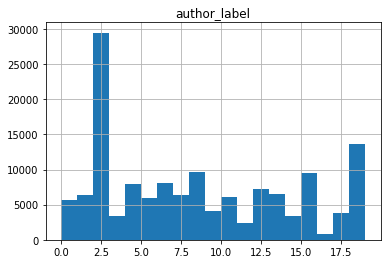

In [ ]:
# Distribution of authors in dataset
text_df.hist('author_label', bins=np.arange(0, 20));
print(len(text_df[text_df['author_label'] == 2])/len(text_df))

- Sample from representative paragraph dataset and export
  - Get 150 paragraph samples per author

In [ ]:
# Sampling - 150 paragraphs per author
author_samples = text_df.groupby('author_label').apply(lambda x: x.sample(150)).reset_index(drop=True)
author_samples
# Uncomment when exporting
#author_samples.to_csv('gdrive/MyDrive/W266 Term Project/author_samples.csv')

index                                          paragraph  author_label  \
0         6                           LUCIUS. I will, my lord.             0   
1         1               POLONIUS. And let him ply his music.             0   
2         1  ROSENCRANTZ. How can that be, when you have th...             0   
3         7  EDGAR. [_Aside._] Why I do trifle thus with hi...             0   
4         7              REGAN. Jesters do oft prove prophets.             0   
...     ...                                                ...           ...   
2995    186  A wave of revulsion swept over me. What a cons...            19   
2996    193  But for the first time, a shade of uncertainty...            19   
2997    187  We stared at each other—the whole thing was so...            19   
2998    193  “Oil,” said Anthony, thoughtfully surveying th...            19   
2999    187    “On the top of the chest of drawers, monsieur.”            19   

                                title  paragraph_lens  
0                       Julius Caesar               8  
1           Hamlet, Prince of Denmark               9  
2           Hamlet, Prince of Denmark              22  
3            The Tragedy of King Lear              19  
4            The Tragedy of King Lear               8  
...                               ...             ...  
2995  The Mysterious Affair at Styles              16  
2996           The Secret of Chimneys              15  
2997              Poirot Investigates              14  
2998           The Secret of Chimneys              23  
2999              Poirot Investigates              13  

[3000 rows x 5 columns]

- Create test set from unused data/data not in `author_samples`

In [ ]:
# Create test set
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

t = text_df[['paragraph', 'author_label', 'title', 'paragraph_lens']]
a = author_samples[['paragraph', 'author_label', 'title', 'paragraph_lens']]
test_interim = t.merge(a.drop_duplicates(), 
               on=['paragraph', 'author_label', 'title', 'paragraph_lens'], 
               how='left', 
               indicator=True).groupby('author_label').apply(lambda x: x.sample(10, random_state=42)).reset_index(drop=True)

# Uncomment when exporting
# test.to_csv("gdrive/MyDrive/W266 Term Project/test.csv")

## Exploratory Data Analysis (EDA)
Visualize character counts, count of words in paragraphs, sentence counts for *Pride and Prejudice*

In [ ]:
# Example output of paragraphs function (for Pride and Prejudice)
txt_sample = paragraphs(df['text'][10])
txt_sample[100:110]

[' Mr. Bennet was so odd a mixture of quick parts, sarcastic humour, reserve, and caprice, that the experience of three-and-twenty years had been insufficient to make his wife understand his character. _Her_ mind was less difficult to develop. She was a woman of mean understanding, little information, and uncertain temper. When she was discontented, she fancied herself nervous. The business of her life was to get her daughters married; its solace was visiting and news.',
 ' Chapter 2',
 ' Mr. Bennet was among the earliest of those who waited on Mr. Bingley. He had always intended to visit him, though to the last always assuring his wife that he should not go; and till the evening after the visit was paid she had no knowledge of it. It was then disclosed in the following manner. Observing his second daughter employed in trimming a hat, he suddenly addressed her with,',
 ' “I hope Mr. Bingley will like it, Lizzy.”',
 ' “We are not in a way to know _what_ Mr. Bingley likes,” said her moth

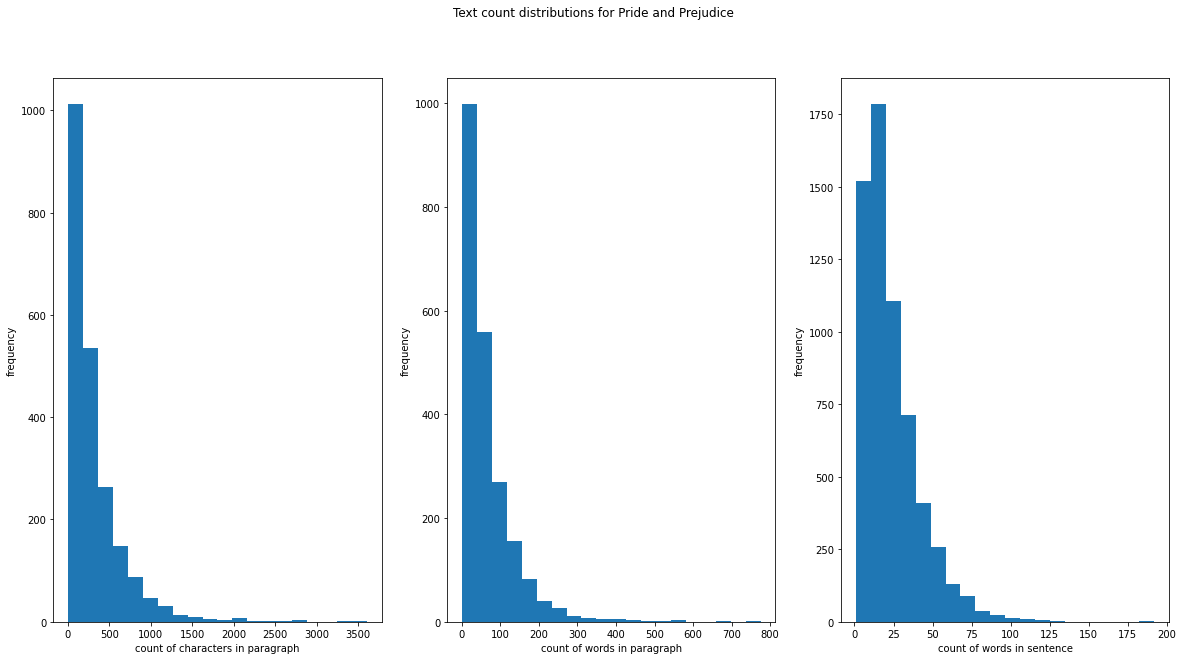

In [ ]:
# Get the number of characters in txt_sample (from "Load Data" section above)
chars_in_parag = [len(i) for i in txt_sample]
# Get number of words in each paragraph of txt_sample
#      Tokenize txt_sample by word from each sentence
words_in_parag = [len(j) for j in [word_tokenize(i) for i in txt_sample]]
# Get number of words in each sentence of each paragraph of txt_sample
#      Get words in each sentence
words_in_sent = [[word_tokenize(j) for j in sent_tokenize(i)] for i in txt_sample]
#      Count words in words_in_sent
word_in_sent_cts = [num for sublist in [[len(j) for j in i] for i in words_in_sent] for num in sublist]

# Visualize character and word count distribution
n_bins = 20

fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=False, figsize = (20, 10))
axs[0].hist(chars_in_parag, bins=n_bins)
axs[0].set_xlabel("count of characters in paragraph")
axs[0].set_ylabel("frequency")
axs[1].hist(words_in_parag, bins=n_bins)
axs[1].set_xlabel("count of words in paragraph")
axs[1].set_ylabel("frequency")
axs[2].hist(word_in_sent_cts, bins=n_bins)
axs[2].set_xlabel("count of words in sentence")
axs[2].set_ylabel("frequency")
title = "Text count distributions for " + df['title'][10]
plt.suptitle(title);

In [ ]:
# Get the middle 50% of sentence lengths in Pride and Prejudice
result = [np.percentile(word_in_sent_cts, 25), np.percentile(word_in_sent_cts, 75)]
print(f"The average 50% of sentences in Pride and Prejudice are between {result[0]} and {result[1]} words long")

The average 50% of sentences in Pride and Prejudice are between 11.0 and 31.0 words long


## TensorFlow’s HuggingFace 🤗 Keras Model
Starting code from [HuggingFaceThreeWays_3_Keras.ipynb](https://github.com/datasci-w266/2021-fall-main/blob/master/materials/walkthrough_notebooks/bert_as_black_box/HuggingFaceThreeWays_3_Keras.ipynb)

- Load author key, value pairs dictionary

In [7]:
author_vals = pickle.load(open("gdrive/MyDrive/W266 Term Project/id2auth.pkl", 'rb'))
author_vals

{0: 'Shakespeare, William',
 1: 'Austen, Jane',
 2: 'Dickens, Charles',
 3: 'Thoreau, Henry David',
 4: 'Sinclair, Upton',
 5: 'Fitzgerald, F. Scott (Francis Scott)',
 6: 'Doyle, Arthur Conan',
 7: 'Barrie, J. M. (James Matthew)',
 8: 'Twain, Mark',
 9: 'Shelley, Mary Wollstonecraft',
 10: 'Plato',
 11: 'Poe, Edgar Allan',
 12: 'Baum, L. Frank (Lyman Frank)',
 13: 'Du Bois, W. E. B. (William Edward Burghardt)',
 14: 'Chesterton, G. K. (Gilbert Keith)',
 15: 'Montgomery, L. M. (Lucy Maud)',
 16: 'Tapper, Thomas',
 17: 'Hawthorne, Nathaniel',
 18: 'Conrad, Joseph',
 19: 'Christie, Agatha'}

- Load sampled representative paragraph dataset

In [8]:
author_samples = pd.read_csv("gdrive/MyDrive/W266 Term Project/author_samples.csv")
author_samples.head(2)

Unnamed: 0  index                                          paragraph  \
0           0      7                KENT. I know you. Where’s the King?   
1           1      3   Wife. A crutch, a crutch! Why call you for a ...   

   author_label                            title  paragraph_lens  
0             0         The Tragedy of King Lear              12  
1             0  The Tragedy of Romeo and Juliet              15

- Load test set from unused data/data not in `author_samples`

In [9]:
test = pd.read_csv("gdrive/MyDrive/W266 Term Project/test.csv")
print(len(test))
test.head(2)

200


Unnamed: 0                                          paragraph  author_label
0          95  _Mid._ [_aside_] My judgement is made up befor...             9
1          15  Her mother too, in whose mind not one speculat...             1

In [10]:
author_samples = shuffle(author_samples, random_state = 42)
author_samples = author_samples[['paragraph', 'author_label']]
test = shuffle(test, random_state=42)
test = test[['paragraph', 'author_label']]

- Set up `author_samples` Dataframe for model input

In [11]:
# Dataset -- Change DF_TO_DATASET with the dataset you want to train on.
DF_TO_DATASET = author_samples

dataset = Dataset.from_pandas(DF_TO_DATASET)
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['paragraph', 'author_label', '__index_level_0__'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['paragraph', 'author_label', '__index_level_0__'],
        num_rows: 600
    })
})

In [12]:
# Check that all labels are represented in training set
set(dataset['train']['author_label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [13]:
# Check that all labels are represented in test set
set(dataset['test']['author_label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [14]:
# Tokenizer Selection
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["paragraph"], padding="max_length", truncation=True)

tokenized_datasets =  dataset.map(tokenize_function, batched=True)

full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
# Create model
LABEL_COUNT = len(author_samples['author_label'].unique())

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=LABEL_COUNT)

# Encode Data
tf_train_dataset = full_train_dataset.remove_columns(["paragraph"]).with_format("tensorflow")
tf_eval_dataset = full_eval_dataset.remove_columns(["paragraph"]).with_format("tensorflow")

train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["author_label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["author_label"]))
eval_tf_dataset = eval_tf_dataset.batch(8)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Adam Optimizer

In [108]:
try:
  ADAM_LEARNING_RATE = float(input("Enter a learning rate: ")) # Getting learning rate
except:
  raise Exception("Must have float or int input for learning rate")

try:
  EPOCH = int(input("Enter an epoch number: ")) # Get epoch number
except:
  raise Exception("Must int input for epoch number")

Enter a learning rate: 3e-5
Enter an epoch number: 3


In [109]:
# Finetuning -- Adam Optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

model.summary()

history = model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=EPOCH)

# Make MODEL_NAME by appending parameter changes to name
# ie. adam5e-2 for a model that has an Adam optimizer with a learning rate of 0.05

MODEL_NAME = f"adam{ADAM_LEARNING_RATE}_epoch{EPOCH}"

# Model Export Code
# model.save_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_model_" + MODEL_NAME)
# tokenizer.save_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_tokenizer_" + MODEL_NAME)

# Model Reload Code
#model = TFAutoModelForSequenceClassification.from_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_model_" + MODEL_NAME)
#tokenizer = AutoTokenizer.from_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_tokenizer_" + MODEL_NAME)

Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_227 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
Total params: 108,325,652
Trainable params: 108,325,652
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
300/300 [==============================] - 216s 657ms/step - loss: 2.4884 - sparse_categorical_accuracy: 0.2708 - val_loss: 1.8629 - val_sparse_categorical_accuracy: 0.4750
Epoch 2/3
300/300 [==============================] - 194s 645ms/step - loss: 1.5137 - sparse_cat

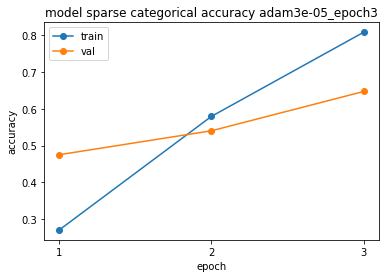

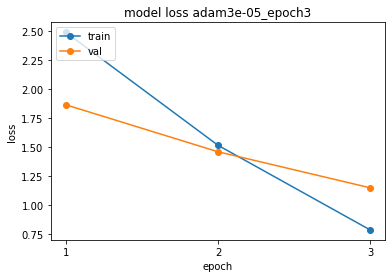

In [110]:
# https://hackernoon.com/how-to-fine-tune-a-hugging-face-transformer-model-581137q7

# Plot categorical accuracy
plt.plot(history.history['sparse_categorical_accuracy'], "o-")
plt.plot(history.history['val_sparse_categorical_accuracy'], "o-")
plt.xticks(np.arange(0,EPOCH), [str(i) for i in range(1,EPOCH+1)])
plt.title('model sparse categorical accuracy ' + MODEL_NAME)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot model loss
plt.plot(history.history['loss'], "o-")
plt.plot(history.history['val_loss'], "o-")
plt.xticks(np.arange(0,EPOCH), [str(i) for i in range(1,EPOCH+1)])
plt.title('model loss ' + MODEL_NAME)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
# https://hackernoon.com/how-to-fine-tune-a-hugging-face-transformer-model-581137q7
eval_loss, eval_acc = model.evaluate(eval_tf_dataset,verbose=2)
print('\nEval accuracy:', eval_acc)

75/75 - 16s - loss: 1.1470 - sparse_categorical_accuracy: 0.6467 - 16s/epoch - 208ms/step

Eval accuracy: 0.6466666460037231


In [112]:
# https://hackernoon.com/how-to-fine-tune-a-hugging-face-transformer-model-581137q7
preds = model(tokenizer(list(test['paragraph']),return_tensors="tf",padding=True,truncation=True))['logits']
class_preds = np.argmax(preds, axis=1)

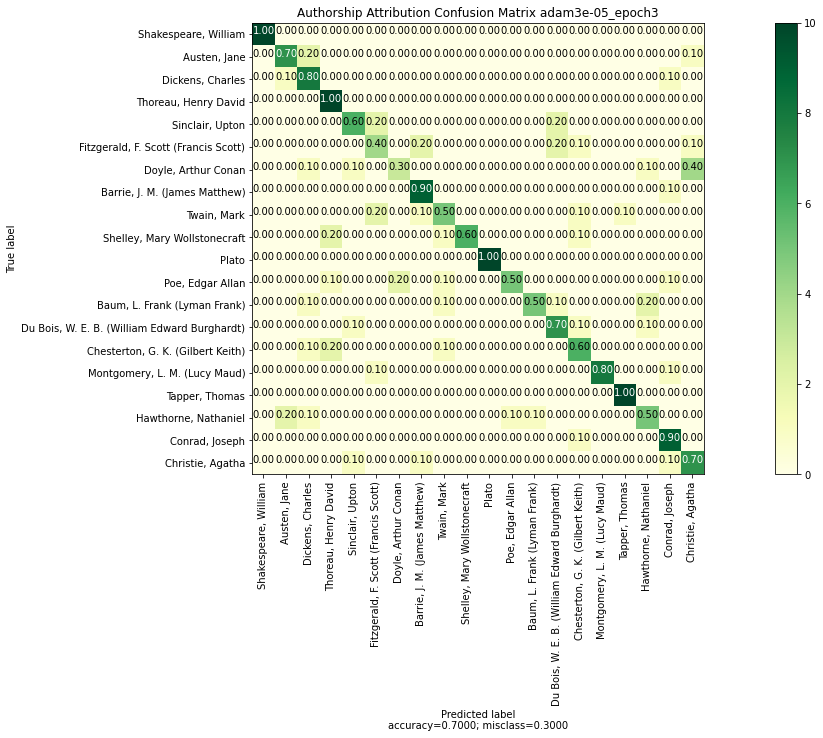

In [113]:
# Create Confusion Matrix
cm = confusion_matrix(y_pred=class_preds, y_true=test['author_label'])
plot_confusion_matrix(cm, target_names=author_vals.values(),
                      title="Authorship Attribution Confusion Matrix " + MODEL_NAME, 
                      cmap="YlGn")

### Stochastic Gradient Descent (SGD) Optimizer

In [16]:
try:
  INIT_LEARN_RATE = float(input("Enter a learning rate: ")) # Getting learning rate
except:
  raise Exception("Must have float or int input for learning rate")

try:
  DECAY_STEPS = int(input("Enter decay steps : ")) # Getting decay steps
except:
  raise Exception("Must have int input for decay steps")

try:
  DECAY_RATE = float(input("Enter decay rate : ")) # Getting decay rate
except:
  raise Exception("Must have float or int input for decay rate")

try:
  EPOCH = int(input("Enter an epoch number: ")) # Get epoch number
except:
  raise Exception("Must int input for epoch number")

Enter a learning rate: 1e-2
Enter decay steps : 10000
Enter decay rate : 0.9
Enter an epoch number: 10


In [17]:
# Finetuning -- SGD
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LEARN_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE)
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)
model.summary()

history = model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=EPOCH)

# Make MODEL_NAME by appending parameter changes to name
# ie. adam5e-2 for a model that has an Adam optimizer with a learning rate of 0.05

MODEL_NAME = f"sgd_epoch{EPOCH}_decay{DECAY_STEPS}_dr{DECAY_RATE}_lr{INIT_LEARN_RATE}"

# Model Export Code
#model.save_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_model_" + MODEL_NAME)
#tokenizer.save_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_tokenizer_" + MODEL_NAME)

# Model Reload Code
#model = TFAutoModelForSequenceClassification.from_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_model_" + MODEL_NAME)
#tokenizer = AutoTokenizer.from_pretrained("gdrive/MyDrive/W266 Term Project/models/auto_tokenizer_" + MODEL_NAME)

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
Total params: 108,325,652
Trainable params: 108,325,652
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
300/300 [==============================] - 216s 646ms/step - loss: 3.0898 - sparse_categorical_accuracy: 0.0637 - val_loss: 3.0581 - val_sparse_categorical_accuracy: 0.0450
Epoch 2/10
300/300 [==============================] - 190s 634ms/step - loss: 3.0588 - sparse_cat

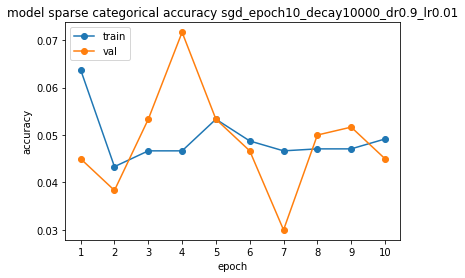

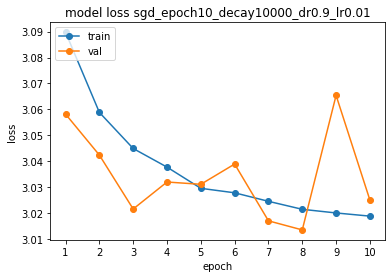

In [18]:
# https://hackernoon.com/how-to-fine-tune-a-hugging-face-transformer-model-581137q7

# Plot categorical accuracy
plt.plot(history.history['sparse_categorical_accuracy'], "o-")
plt.plot(history.history['val_sparse_categorical_accuracy'], "o-")
plt.xticks(np.arange(0,EPOCH), [str(i) for i in range(1,EPOCH+1)])
plt.title('model sparse categorical accuracy ' + MODEL_NAME)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot model loss
plt.plot(history.history['loss'], "o-")
plt.plot(history.history['val_loss'], "o-")
plt.xticks(np.arange(0,EPOCH), [str(i) for i in range(1,EPOCH+1)])
plt.title('model loss ' + MODEL_NAME)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
# https://hackernoon.com/how-to-fine-tune-a-hugging-face-transformer-model-581137q7
eval_loss, eval_acc = model.evaluate(eval_tf_dataset,verbose=2)
print('\nEval accuracy:', eval_acc)

75/75 - 16s - loss: 3.0249 - sparse_categorical_accuracy: 0.0450 - 16s/epoch - 207ms/step

Eval accuracy: 0.04500000178813934


In [20]:
# https://hackernoon.com/how-to-fine-tune-a-hugging-face-transformer-model-581137q7
preds = model(tokenizer(list(test['paragraph']),return_tensors="tf",padding=True,truncation=True))['logits']
class_preds = np.argmax(preds, axis=1)

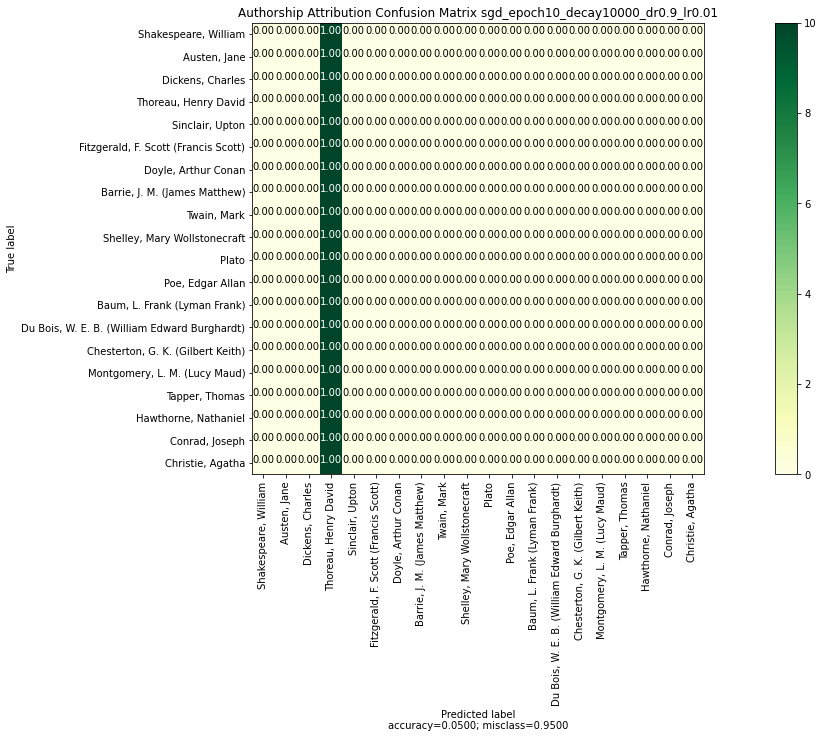

In [21]:
# Create Confusion Matrix
cm = confusion_matrix(y_pred=class_preds, y_true=test['author_label'])
plot_confusion_matrix(cm, target_names=author_vals.values(),
                      title="Authorship Attribution Confusion Matrix " + MODEL_NAME, 
                      cmap="YlGn")

In [149]:
del model